In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

from PIL import Image
from scipy import ndimage as ndi
from skimage.filters import sobel, rank, gaussian
from skimage.morphology import disk, remove_small_objects
from skimage.segmentation import watershed, felzenszwalb, slic, morphological_geodesic_active_contour, inverse_gaussian_gradient
from skimage.feature import peak_local_max, canny
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage import exposure

from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import LabelPropagation

from tqdm import tqdm
import torch

from skimage import io, img_as_float, exposure
from skimage.filters import gaussian
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid


c:\Users\sacha\miniconda3\envs\ECN_APP_PROF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Loading

In [2]:
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [3]:
data_train_path = Path('data/images_hTE3Lse/images')
data_test_path = Path('data/images_ZKlXDOZ/images')

data_train = load_dataset(data_train_path)
print("Loaded data_train:", data_train.shape)
data_test = load_dataset(data_test_path)
print("Loaded data_test:", data_test.shape)

Loaded data_train: (2000, 512, 512)
Loaded data_test: (500, 512, 512)


In [4]:
# Load half-supervised labels
labels = pd.read_csv(
    'data/label_rphifOX.csv',
    index_col=0,
)
print("Loaded labels:", labels.shape)
labels = labels.T
labels.head()

Loaded labels: (262144, 2000)


,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 262134,Pixel 262135,Pixel 262136,Pixel 262137,Pixel 262138,Pixel 262139,Pixel 262140,Pixel 262141,Pixel 262142,Pixel 262143
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Display the first 5 label maps
sum_per_line = labels.sum(axis=1)
index_supervised = sum_per_line[sum_per_line > 0].index
print("Count with labels:", len(index_supervised))
print("Indexes with labels:", index_supervised.tolist())


Count with labels: 400
Indexes with labels: ['0.png', '1.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', '10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '48.png', '49.png', '50.png', '51.png', '52.png', '53.png', '54.png', '55.png', '56.png', '57.png', '58.png', '59.png', '60.png', '61.png', '62.png', '63.png', '64.png', '65.png', '66.png', '67.png', '68.png', '69.png', '70.png', '71.png', '72.png', '73.png', '74.png', '75.png', '76.png', '77.png', '78.png', '79.png', '80.png', '81.png', '82.png', '83.png', '84.png', '85.png', '86.png', '87.png', '88.png', '89.png', '90.png', '91.png', '92.png', '93.png', '94.png', '95.png', '96.p

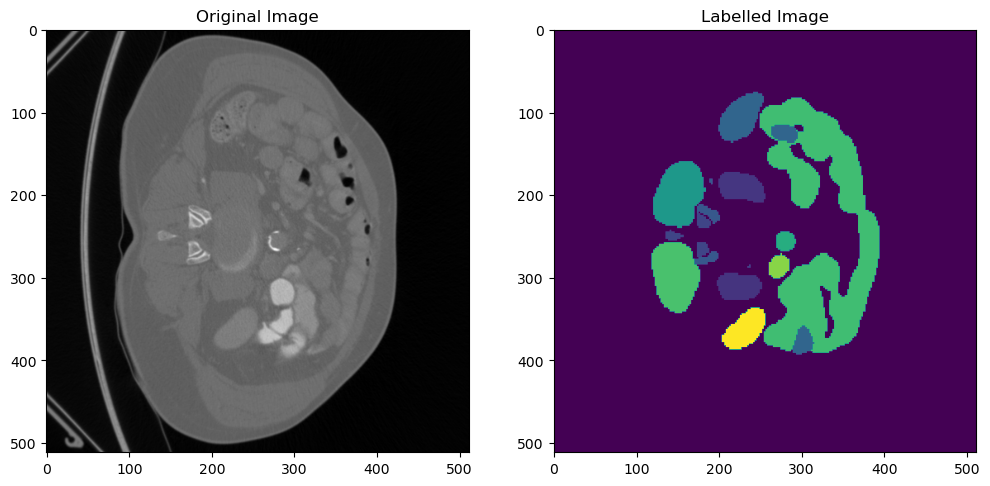

In [6]:
def label_to_image(label):
    return label.to_numpy().reshape(512, 512)

test = labels.iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original image
axs[0].imshow(data_train[0], cmap='gray')
axs[0].set_title('Original Image')

# Plot the label image
axs[1].imshow(label_to_image(test))
axs[1].set_title('Labelled Image')

plt.show()

### 2. Pre-Processing Functions

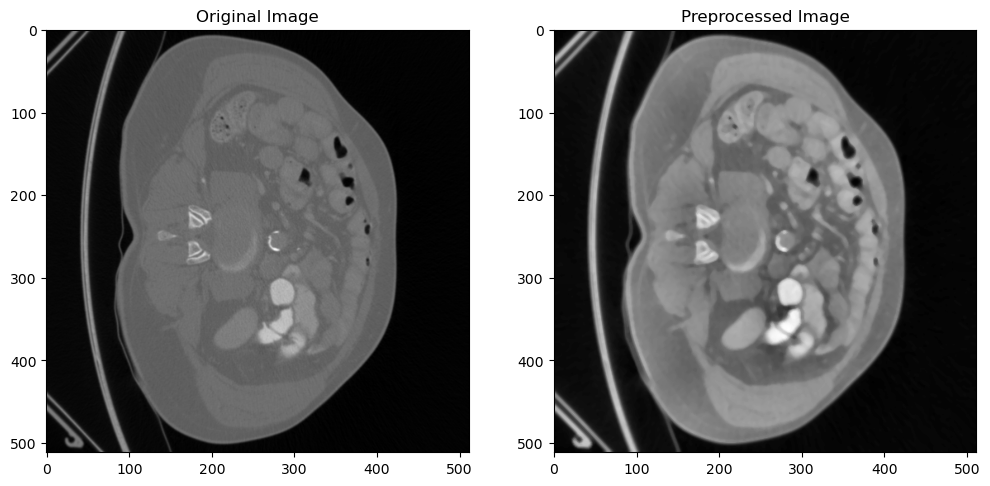

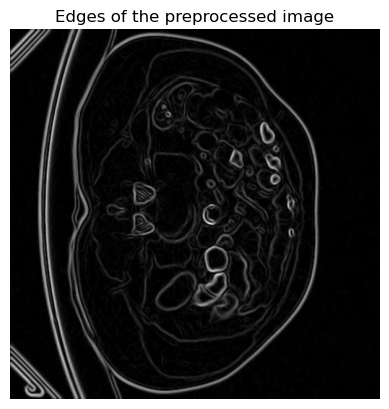

In [7]:


def preprocess_image(image):
    # Convert to float
    image = img_as_float(image)
    # Apply Gaussian filter for smoothing
    smoothed = gaussian(image, sigma=1)
    # Enhance contrast using adaptive histogram equalization
    equalized = exposure.equalize_adapthist(smoothed)
    # Normalize the intensity values
    normalized = (equalized - np.min(equalized)) / (np.max(equalized) - np.min(equalized))
    # Apply median filter to remove noise
    denoised = ndi.median_filter(normalized, size=5)
    return denoised

def get_edges(image):
    edges = sobel(image)
    edges_int = (edges * 255).astype(np.uint8)
    return edges_int

# Test preprocessing on one image
image = data_train[0]
preprocessed_image = preprocess_image(image)

# Visualize original and preprocessed image
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image, cmap='gray')
axs[1].set_title('Preprocessed Image')
plt.show()

edges = get_edges(preprocessed_image)

plt.imshow(edges, cmap='gray')
plt.title('Edges of the preprocessed image')
plt.axis('off')
plt.show()

def label_to_image(label):
    return label.to_numpy().reshape(512, 512)

### 3. Feature Extraction

In [8]:
def extract_pixel_features(image):
    # Preprocess the image
    preprocessed_image = preprocess_image(image)
    # Compute gradients
    sobel_edges = sobel(preprocessed_image)
    gradient_magnitude = np.sqrt(
        ndi.sobel(preprocessed_image, axis=0, mode='constant')**2 + 
        ndi.sobel(preprocessed_image, axis=1, mode='constant')**2
    ).flatten()
    # Get spatial coordinates
    height, width = preprocessed_image.shape
    X, Y = np.meshgrid(np.arange(width), np.arange(height))
    X = X.flatten()
    Y = Y.flatten()
    # Flatten intensity values
    pixel_values = preprocessed_image.flatten()
    # Stack features
    features = np.stack((pixel_values, gradient_magnitude, X, Y), axis=-1)
    return features

### 4. PCA

In [9]:
from sklearn.model_selection import train_test_split

# Collect features and labels from the labeled images
all_features = []
all_labels = []

print("Extracting features from labeled images...")
for idx in tqdm(index_supervised):
    image = data_train[idx]
    label_series = labels_df.iloc[idx]
    label_image = label_to_image(label_series)
    # Flatten labels
    labels_flat = label_image.flatten()
    # Extract features
    features = extract_pixel_features(image)
    # Append to the list
    all_features.append(features)
    all_labels.append(labels_flat)

# Convert lists to arrays
all_features = np.vstack(all_features)
all_labels = np.hstack(all_labels)

print("Feature shape:", all_features.shape)
print("Labels shape:", all_labels.shape)

Extracting features from labeled images...


  0%|          | 0/400 [00:00<?, ?it/s]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices